# Analiza danych - zanieczyszczenie na całym świecie w okresie 2010-2021
## Michał Sawicki

## Wprowadzenie

PM2.5 to aerozole atmosferyczne, których średnica nie jest większa niż 2.5 mikrometra. Tego rodzaju pył zawieszony jest uznawany za najgroźniejszy dla zdrowia człowieka. Wszystko dlatego, że pył jest bardzo drobny, a w takiej postaci może się przedostać bezpośrednio do krwiobiegu. WHO ustaliło normę średniego dobowego stężenia pyłu zawieszonego PM2.5 na 25 mikrogramów na metr sześcienny, a roczna norma to 10 mikrogramów na metr sześcienny.

PM10 to mieszanina zawieszonych w powietrzu cząsteczek, których średnica nie przekracza 10 mikrometrów. Jest szkodliwy z uwagi na zawartość takich elementów jak benzopireny, furany, dioksyny – jednym słowem, rakotwórcze metale ciężkie. Norma średniego, dobowego stężenia tego pyłu wynosi według WHO 50 mikrogramów na metr sześcienny, a roczna 20 mikrogramów na metr sześcienny.

Tlenki azotu to jedne z najbardziej niebezpiecznych składników smogu. Ich toksyczność jest wielokrotnie większa w porównaniu do tlenku węgla czy dwutlenku siarki. Szczególnie groźny dla zdrowia człowieka jest dwutlenek azotu w powietrzu (NO2), który najczęściej powstaje na skutek utleniania tlenku azotu (NO) w atmosferze. Pozostałe tlenki azotu nie stanowią niebezpieczeństwa lub nie występują w stanie wolnym. Źródło: Airly.org

# Wczytanie danych i bibliotek

In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from tqdm import tqdm
import plotly.express as px
import ipywidgets as widgets
from itables import init_notebook_mode
from itables import show

In [3]:
data = pd.read_excel('C:/ML_Prezentacja/projekt_Zanieczyszczenia/data.xlsx',sheet_name='AAP_2022_city_v9')
print(len(data))

32191


In [4]:
#data_test = pd.read_excel('C:/ML_Prezentacja/projekt_Zanieczyszczenia/data.xlsx', sheet_name='AAP_2022_city_v9')
#show(data_test)

Interaktywna tabela pozwala nam w dużo czytelniejszy i prostszy sposób przeglądać

# Usunięcie danych
Pierwszym krokiem jest usunięcie danych, które dają nam jedynie informację o NO2. Uważam, że te dane nie dają nam dużego wglądu w temacie zanieczyszczenia środowiska


In [5]:
# Wybór wierszy, gdzie PM2.5 i PM10 mają puste wartości
missing_values_rows = data[data['PM2.5 (μg/m3)'].isnull() & data['PM10 (μg/m3)'].isnull()]
print("Liczba wierszy, gdzie PM2.5 i PM10 mają puste wartości:", len(missing_values_rows))

Liczba wierszy, gdzie PM2.5 i PM10 mają puste wartości: 4858


In [6]:
# Usunięcię wierszy z pustymi rekordami zarówno dla PM2.5 jak i dla PM10
data = data.dropna(subset=['PM2.5 (μg/m3)', 'PM10 (μg/m3)'], how='all')
# Usunięcie danych z lat poniżej 2010 roku, ponieważ dla jednego z krajów podawane są dane z lat wcześniejszych
data = data[data['Measurement Year'] >= 2010]
print(data[['City or Locality', 'PM2.5 (μg/m3)', 'PM10 (μg/m3)']].head(30))

      City or Locality  PM2.5 (μg/m3)  PM10 (μg/m3)
0                Kabul         119.77           NaN
1               Durres            NaN         17.65
2               Durres          14.32         24.56
6                Korce          30.34         45.31
7                Korce          28.64         40.21
8                Vlore            NaN         15.25
9                Vlore            NaN         19.39
10               Vlore            NaN         22.71
11               Vlore          10.32           NaN
12               Vrith          13.24         19.52
13  Escaldes-Engordany            NaN         27.50
14  Escaldes-Engordany            NaN         25.03
15  Escaldes-Engordany            NaN         27.04
16  Escaldes-Engordany            NaN         26.26
17  Escaldes-Engordany            NaN         26.30
18  Escaldes-Engordany            NaN         23.20
19  Escaldes-Engordany            NaN         24.58
20           Abu Dhabi            NaN        158.18
21          

# Uzupełnienie danych
Uzupełnione zostały kolumny PM2.5 oraz PM10 w wierszach gdzie brakowało jednej z danych. Została obliczona średnia na podstawie różnicy między wartością PM10, a PM2.5 biorąc pod uwagę cały okres danych. Taką średnią można obliczyć na różnych stopniach generalizacji. W tym przypadku średnia została obliczona poprzez grupowanie kolumny "City or Locality", ponieważ jest to najwiarygodniejsza opcja, gdyż uwzględnia tylko wartości dla jednego miasta/lokalizacji, a nie dla regionu lub kraju. Następnie brakujące wartości, np. dla PM2.5, zostały uzupełnione poprzez odjęcie od wartości PM10 uzyskanej średniej. Jeżeli dla danego miasta w całym okresie gromadzonych dla niego danych, nie było żadnych wartości np. dla PM10 i nie została obliczona przez to średnia, w tym przypadku nie uzupełniano brakujących wartości. Zastosowano taką metodę, ponieważ PM2.5 często zawiera się w PM10, a ich wartości korelują się. Wykorzystanie średniej w stopniu generalizacji jakim jest jedynie miasto, dla którego uzupełniamy dane, pozwala na stosunkowo dokładną predykcję brakujących danych. Uwzględniona zostaje w ten sposób specyfikacja danej lokalizacji


In [7]:
# Obliczenie różnic między PM10 a PM2.5 dla każdego miasta
difference_by_city = data.groupby('City or Locality')[['PM10 (μg/m3)', 'PM2.5 (μg/m3)']].apply(lambda x: x['PM10 (μg/m3)'] - x['PM2.5 (μg/m3)'])

# Uzupełnienie brakujących wartości na podstawie różnicy
data['PM2.5 (μg/m3)'] = data.apply(
    lambda row: round(row['PM10 (μg/m3)'] - difference_by_city[row['City or Locality']].mean(), 2) if pd.isna(
        row['PM2.5 (μg/m3)']) else row['PM2.5 (μg/m3)'], axis=1)
data['PM10 (μg/m3)'] = data.apply(
    lambda row: round(row['PM2.5 (μg/m3)'] + difference_by_city[row['City or Locality']].mean(), 2) if pd.isna(
        row['PM10 (μg/m3)']) else row['PM10 (μg/m3)'], axis=1)

print(data[['City or Locality', 'PM2.5 (μg/m3)', 'PM10 (μg/m3)']].head(30))

      City or Locality  PM2.5 (μg/m3)  PM10 (μg/m3)
0                Kabul         119.77           NaN
1               Durres           7.41         17.65
2               Durres          14.32         24.56
6                Korce          30.34         45.31
7                Korce          28.64         40.21
8                Vlore            NaN         15.25
9                Vlore            NaN         19.39
10               Vlore            NaN         22.71
11               Vlore          10.32           NaN
12               Vrith          13.24         19.52
13  Escaldes-Engordany            NaN         27.50
14  Escaldes-Engordany            NaN         25.03
15  Escaldes-Engordany            NaN         27.04
16  Escaldes-Engordany            NaN         26.26
17  Escaldes-Engordany            NaN         26.30
18  Escaldes-Engordany            NaN         23.20
19  Escaldes-Engordany            NaN         24.58
20           Abu Dhabi          78.63        158.18
21          

Usunięcie wartości, które po utworzeniu są mniejsze od 2. Próg został ustalony na 2 μg/m3, ponieważ dla większości czujników prawidłowe i dokładne dane liczone są do   ok. 1 μg/m3. Biorąc pod uwagę występowanie w danych krajów afrykańskich oraz innych krajów mniej rozwiniętych, ich techika pomiaru może nie być tak bardzo dokładna, dlatego bierzemy pod uwagę jedynie wartości większe od 2μg/m3.


In [8]:
data = data[(data['PM2.5 (μg/m3)'] >= 2)]
print(len(data))

17614


# Pozyskanie długości i szerokości geograficznej
Głównym założeniem było pozyskanie koordynatów za pomocą biblioteki geopy - Nominatium.
Danych jest dużo i czas poszukiwania odpowiednich koordynatów dla miast jest długi, dlatego zostały pobrana tabela z danymi dla miast z całego świata, która posiada kolumnę Coordinates.


In [10]:
data2 = pd.read_excel('C:/ML_Prezentacja/projekt_Zanieczyszczenia/cities_names.xlsx', engine='openpyxl')

# Wyodrębnienie unikalnych miast z obu plików z danymi
cities1 = set(data['City or Locality'].unique())
cities2 = set(data2['ASCII Name'].unique())

# Znalezienie wspólnych miast w obu plikach
common_cities = cities1.intersection(cities2)

# Filtracja danych z pliku2 dla miast wspólnych
filtered_data2 = data2[data2['ASCII Name'].isin(common_cities)]

# Połączenie dane1 i dane2 na podstawie wspólnych miast, dodając kolumny z dane2
merged_data = pd.merge(data, filtered_data2[['ASCII Name', 'Coordinates']], left_on='City or Locality', right_on='ASCII Name', suffixes=('_data', '_data1'), how='left')

merged_data.to_excel('C:/ML_Prezentacja/projekt_Zanieczyszczenia/cities_names_coordinates.xlsx', index=False)

In [14]:
# Sprawdzenie ile zostało nieuzupełnionych danych
empty_coordinates_data = merged_data[merged_data['Coordinates'].isna()].copy()
empty_coordinates_count = merged_data['Coordinates'].isna().sum()
print("Liczba pustych rekordów w tabeli Coordinates:", empty_coordinates_count)

Liczba pustych rekordów w tabeli Coordinates: 6980


Wyżej możemy zobaczyć, że nadal występują rekordy - miasta, które nie mają dopisanych współrzędnych.
Jest to często spowodowane różnicą w nazwie miasta, np. w jednym pliku dodawane jest słowo "City", a w drugim nie.
W tym przypadku po zmniejszeniu ilości miast bez koordynatów, użyto wcześniej wspomnianego pakietu geopy, który umożliwia pobranie współrzędnych na podstawie nazwy miasta.

In [15]:
# Stworzenie nowego pliku jedynie z danymi bez koordynatów, bez powtarzania miast
data_unique_cities = empty_coordinates_data.drop_duplicates(subset='City or Locality', keep='first')
data_unique_cities.to_excel('C:/ML_Prezentacja/projekt_Zanieczyszczenia/unique_cities.xlsx', index=False)

In [16]:
# Funkcja do pobierania koordynatów dla danego miasta
def get_coordinates(city):
    try:
        geolocator = Nominatim(user_agent="geoapiExercises")
        location = geolocator.geocode(city)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        return None, None

Poniższy kod został zakomentowany, ponieważ jego wykonywanie trwa około 30-40 min.

In [17]:
# Utworzony został pasek postępu aby wiedzieć ile zostało do zakończenia kompilacji
# pbar = tqdm(total=len(data_unique_cities), desc="Updating coordinates")
# # Aktualizacja wartości kolumny Coordinates, wykorzystując funkcję get_coordinates
# for index, row in data_unique_cities.iterrows():
#     city = row['City or Locality']
#     latitude, longitude = get_coordinates(city)
#     data_unique_cities.at[index, 'Latitude'] = latitude
#     data_unique_cities.at[index, 'Longitude'] = longitude
#     pbar.update(1)

# pbar.close()

# data_unique_cities.to_excel('C:/ML_Prezentacja/projekt_Zanieczyszczenia/unique_cities_with_coordinates.xlsx',index=False)

Przygotowanie danych do połączenia współrzędnych geograficznych z dwóch plików

In [18]:
cities_coordinates = pd.read_excel('C:/ML_Prezentacja/projekt_Zanieczyszczenia/cities_names_coordinates.xlsx')
cities_coordinates[['Latitude', 'Longitude']] = cities_coordinates['Coordinates'].str.split(',', expand=True)
#Usunięcie niepotrzebnej już kolumny Coordinates
cities_coordinates.drop(columns=['Coordinates'], inplace=True)

cities_coordinates.to_excel('C:/ML_Prezentacja/projekt_Zanieczyszczenia/cities_names_coordinates_updated.xlsx', index=False)
cities_names_coordinates = pd.read_excel('C:/ML_Prezentacja/projekt_Zanieczyszczenia/cities_names_coordinates_updated.xlsx')
unique_cities_with_coordinates = pd.read_excel('C:/ML_Prezentacja/projekt_Zanieczyszczenia/unique_cities_with_coordinates.xlsx')

Łączenie danych na podstawie wspólnej kolumny "City or Locality"

In [19]:
data = pd.merge(data, cities_names_coordinates[['City or Locality', 'Longitude', 'Latitude']], on='City or Locality', how='left')
data= pd.merge(data, unique_cities_with_coordinates[['City or Locality', 'Longitude', 'Latitude']], on='City or Locality', how='left')
# Wybranie kolumny Longitude i Latitude
data['Longitude'] = data['Longitude_x'].fillna(data['Longitude_y'])
data['Latitude'] = data['Latitude_x'].fillna(data['Latitude_y'])
# Usunięcie zbędnych kolumn pomocniczych
data.drop(['Longitude_x', 'Latitude_x', 'Longitude_y', 'Latitude_y'], axis=1, inplace=True)
data.drop_duplicates(subset=['City or Locality', 'Measurement Year'], inplace=True)
data.loc[data['City or Locality'] == 'Adelaide', ['Latitude', 'Longitude']] = [-34.921230, 138.599503]
# Zapisywanie danych do pliku
data.to_excel('C:/ML_Prezentacja/projekt_Zanieczyszczenia/data_ready.xlsx', index=False)

# Wizualizacja danych - Mapy

Stworzenie listy krajów, które wchodzą w poszczególne regiony

In [20]:
dane = pd.read_excel('C:/ML_Prezentacja/projekt_Zanieczyszczenia/data_ready.xlsx')

countries_in_regions = {}

# Grupowanie danych po regionie i unikalnych krajach
region_country_data = dane.groupby('WHO Region')['WHO Country Name'].unique()

for region, countries in region_country_data.items():
    countries_in_regions[region] = countries

# Wyświetlenie listy krajów wchodzących w poszczególne regiony
for region, countries in countries_in_regions.items():
    print(f"{region}: {', '.join(countries)}\n")


African Region: Cameroon, Algeria, Ethiopia, Ghana, Kenya, Madagascar, Nigeria, Senegal, United Republic of Tanzania, Uganda, South Africa

Eastern Mediterranean Region: Afghanistan, United Arab Emirates, Bahrain, Iran (Islamic Republic of), Iraq, Jordan, Kuwait, Lebanon, Pakistan, Qatar, Saudi Arabia

European Region: Albania, Austria, Belgium, Bulgaria, Bosnia and Herzegovina, Switzerland, Cyprus, Czechia, Germany, Denmark, Spain, Estonia, Finland, France, United Kingdom, Georgia, Greece, Croatia, Hungary, Ireland, Iceland, Israel, Italy, Kazakhstan, Kyrgyzstan, Lithuania, Luxembourg, Latvia, North Macedonia, Malta, Netherlands, Norway, Poland, Portugal, Romania, Russian Federation, Serbia, Slovakia, Slovenia, Sweden, Tajikistan, Turkmenistan, Turkey, Ukraine, Uzbekistan

Region of the Americas: Argentina, Bahamas, Brazil, Canada, Chile, Colombia, Costa Rica, Cuba, Ecuador, Guatemala, Honduras, Mexico, Panama, Peru, Paraguay, El Salvador, Trinidad and Tobago, Uruguay, United States o

## Region - Europa

In [21]:
# Funkcja do aktualizacji mapy
def update_map(selected_pollutant):
    # Filtracja danych dla regionu Europy
    europe_data = dane[dane['WHO Region'] == 'European Region']

    # Usunięcie wierszy, w których wybrany czynnik jest null
    europe_data_filtered = europe_data.dropna(subset=[selected_pollutant])

    # Sortowanie danych po roku
    europe_data_sorted = europe_data_filtered.sort_values(by='Measurement Year')

    # Tworzenie interaktywnej mapy z jednakową skalą wartości dla wszystkich lat
    fig = px.scatter_mapbox(europe_data_sorted, lat='Latitude', lon='Longitude', color=selected_pollutant,
                            hover_name='City or Locality', hover_data=[selected_pollutant, 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                            animation_frame='Measurement Year',
                            title=f'Zanieczyszczenie powietrza w regionie Europy na przestrzeni lat 2010-2020 ({selected_pollutant})',
                            mapbox_style='carto-positron', zoom=3, height=750,
                            range_color=[europe_data_sorted[selected_pollutant].min(), europe_data_sorted[selected_pollutant].max()],
                            center={'lat': europe_data_sorted['Latitude'].mean(), 'lon': europe_data_sorted['Longitude'].mean()})
    # Wyświetlenie mapy
    fig.show()

# Tworzenie interaktywnego select boxa dla czynnika zanieczyszczenia
select_pollutant = widgets.Dropdown(options=['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'], description='Czynnik:', style={'description_width': 'initial'})

# Wywołanie funkcji update_map po zmianie wartości select boxa
widgets.interactive(update_map, selected_pollutant=select_pollutant)

interactive(children=(Dropdown(description='Czynnik:', options=('PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'…

In [22]:
# Funkcja do aktualizacji mapy po wybraniu kraju, roku i czynnika
def update_map(selected_pollutant, selected_country, selected_year):
    # Filtracja danych dla wybranego kraju, roku i czynnika
    country_year_pollutant_data = dane[(dane['WHO Country Name'] == selected_country) & 
                                       (dane['Measurement Year'] == selected_year) &
                                       (dane[selected_pollutant].notna())]
    
    # Tworzenie interaktywnej mapy dla wybranego kraju, roku i czynnika
    fig = px.scatter_mapbox(country_year_pollutant_data, lat='Latitude', lon='Longitude', color=selected_pollutant,
                            hover_name='City or Locality', hover_data=[selected_pollutant, 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                            title=f'Zanieczyszczenie powietrza w kraju: {selected_country}, rok: {selected_year} ({selected_pollutant})',
                            mapbox_style='carto-positron', zoom=3, height=600,
                            range_color=[country_year_pollutant_data[selected_pollutant].min(), country_year_pollutant_data[selected_pollutant].max()],
                            center={'lat': country_year_pollutant_data['Latitude'].mean(), 'lon': country_year_pollutant_data['Longitude'].mean()})
    
    # Wyświetlenie mapy
    fig.show()

# Funkcja do aktualizacji dostępnych czynników zanieczyszczenia dla wybranego kraju
def update_pollutants_options(selected_country):
    available_pollutants = ['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']
    select_pollutant.options = available_pollutants

    # Sprawdzenie czy domyślna wartość jest obecna na liście dostępnych czynników zanieczyszczenia dla wybranego kraju
    if select_pollutant.value not in available_pollutants:
        select_pollutant.value = available_pollutants[0]  # Ustawienie pierwszego dostępnego czynnika jako domyślną wartość
    
    # Aktualizacja dostępnych krajów na podstawie wybranego czynnika
    available_countries = dane[dane[selected_pollutant].notna()]['WHO Country Name'].unique()
    select_country.options = available_countries

    # Sprawdzenie czy wybrany kraj jest obecny na liście dostępnych krajów dla wybranego czynnika
    if select_country.value not in available_countries:
        select_country.value = available_countries[0]  # Ustawienie pierwszego dostępnego kraju jako domyślną wartość

# Funkcja do aktualizacji dostępnych lat dla wybranego kraju i czynnika
def update_years_options(selected_country, selected_pollutant):
    available_years = sorted(dane[(dane['WHO Country Name'] == selected_country) & 
                                  (dane[selected_pollutant].notna())]['Measurement Year'].unique())
    select_year.options = available_years

    # Sprawdzenie czy wybrany rok jest obecny na liście dostępnych lat dla wybranego kraju i czynnika
    if select_year.value not in available_years:
        select_year.value = available_years[0]  # Ustawienie pierwszego dostępnego roku jako domyślną wartość

# Lista dostępnych krajów w Region of the Americas
european_countries = dane[dane['WHO Region'] == 'European Region']['WHO Country Name'].unique()

# Tworzenie interaktywnych select boxów
select_pollutant = widgets.Dropdown(description='Czynnik:', style={'description_width': 'initial'})
select_country = widgets.Dropdown(options=european_countries, description='Kraj:', style={'description_width': 'initial'})
select_year = widgets.Dropdown(description='Rok:', style={'description_width': 'initial'})

widgets.interactive(update_years_options, selected_country=select_country, selected_pollutant=select_pollutant)
widgets.interactive(update_pollutants_options, selected_country=select_country)

widgets.interactive(update_map, selected_pollutant=select_pollutant, selected_country=select_country, selected_year=select_year)


interactive(children=(Dropdown(description='Czynnik:', options=('PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'…

## Region - Bliski Wschód

In [23]:
# Funkcja do aktualizacji mapy
def update_map(selected_pollutant):
    # Filtracja danych dla regionu Mediterranean
    mediterranean_data = dane[dane['WHO Region'] == 'Eastern Mediterranean Region']

    # Usunięcie wierszy, w których wybrany czynnik jest null
    mediterranean_data_filtered = mediterranean_data.dropna(subset=[selected_pollutant])

    # Sortowanie danych po roku
    mediterranean_data_sorted = mediterranean_data_filtered.sort_values(by='Measurement Year')

    # Tworzenie interaktywnej mapy z jednakową skalą wartości dla wszystkich lat
    fig = px.scatter_mapbox(mediterranean_data_sorted, lat='Latitude', lon='Longitude', color=selected_pollutant,
                            hover_name='City or Locality', hover_data=[selected_pollutant, 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                            animation_frame='Measurement Year',
                            title=f'Zanieczyszczenie powietrza w regionie Mediterranean na przestrzeni lat 2010-2020 ({selected_pollutant})',
                            mapbox_style='carto-positron', zoom=3, height=750,
                            range_color=[mediterranean_data_sorted[selected_pollutant].min(), mediterranean_data_sorted[selected_pollutant].max()],
                            center={'lat': mediterranean_data_sorted['Latitude'].mean(), 'lon': mediterranean_data_sorted['Longitude'].mean()})
    # Wyświetlenie mapy
    fig.show()

# Tworzenie interaktywnego select boxa dla czynnika zanieczyszczenia
select_pollutant = widgets.Dropdown(options=['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'], description='Czynnik:', style={'description_width': 'initial'})

# Wywołanie funkcji update_map po zmianie wartości select boxa
widgets.interactive(update_map, selected_pollutant=select_pollutant)

interactive(children=(Dropdown(description='Czynnik:', options=('PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'…

In [24]:
# Funkcja do aktualizacji mapy po wybraniu kraju, roku i czynnika
def update_map(selected_pollutant, selected_country, selected_year):
    # Filtracja danych dla wybranego kraju, roku i czynnika
    country_year_pollutant_data = dane[(dane['WHO Country Name'] == selected_country) & 
                                       (dane['Measurement Year'] == selected_year) &
                                       (dane[selected_pollutant].notna())]
    
    # Tworzenie interaktywnej mapy dla wybranego kraju, roku i czynnika
    fig = px.scatter_mapbox(country_year_pollutant_data, lat='Latitude', lon='Longitude', color=selected_pollutant,
                            hover_name='City or Locality', hover_data=[selected_pollutant, 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                            title=f'Zanieczyszczenie powietrza w kraju: {selected_country}, rok: {selected_year} ({selected_pollutant})',
                            mapbox_style='carto-positron', zoom=3, height=600,
                            range_color=[country_year_pollutant_data[selected_pollutant].min(), country_year_pollutant_data[selected_pollutant].max()],
                            center={'lat': country_year_pollutant_data['Latitude'].mean(), 'lon': country_year_pollutant_data['Longitude'].mean()})
    
    # Wyświetlenie mapy
    fig.show()

# Funkcja do aktualizacji dostępnych czynników zanieczyszczenia dla wybranego kraju
def update_pollutants_options(selected_country):
    available_pollutants = ['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']
    select_pollutant.options = available_pollutants

    # Sprawdzenie czy domyślna wartość jest obecna na liście dostępnych czynników zanieczyszczenia dla wybranego kraju
    if select_pollutant.value not in available_pollutants:
        select_pollutant.value = available_pollutants[0]  # Ustawienie pierwszego dostępnego czynnika jako domyślną wartość
    
    # Aktualizacja dostępnych krajów na podstawie wybranego czynnika
    available_countries = dane[dane[selected_pollutant].notna()]['WHO Country Name'].unique()
    select_country.options = available_countries

    # Sprawdzenie czy wybrany kraj jest obecny na liście dostępnych krajów dla wybranego czynnika
    if select_country.value not in available_countries:
        select_country.value = available_countries[0]  # Ustawienie pierwszego dostępnego kraju jako domyślną wartość

# Funkcja do aktualizacji dostępnych lat dla wybranego kraju i czynnika
def update_years_options(selected_country, selected_pollutant):
    available_years = sorted(dane[(dane['WHO Country Name'] == selected_country) & 
                                  (dane[selected_pollutant].notna())]['Measurement Year'].unique())
    select_year.options = available_years

    # Sprawdzenie czy wybrany rok jest obecny na liście dostępnych lat dla wybranego kraju i czynnika
    if select_year.value not in available_years:
        select_year.value = available_years[0]  # Ustawienie pierwszego dostępnego roku jako domyślną wartość

# Lista dostępnych krajów w Region of the Americas
arabic_countries = dane[dane['WHO Region'] == 'Eastern Mediterranean Region']['WHO Country Name'].unique()

# Tworzenie interaktywnego select boxów
select_pollutant = widgets.Dropdown(description='Czynnik:', style={'description_width': 'initial'})
select_country = widgets.Dropdown(options=arabic_countries, description='Kraj:', style={'description_width': 'initial'})
select_year = widgets.Dropdown(description='Rok:', style={'description_width': 'initial'})

# Po wyborze kraju, aktualizuj dostępne lata i czynniki zanieczyszczenia
widgets.interactive(update_years_options, selected_country=select_country, selected_pollutant=select_pollutant)
widgets.interactive(update_pollutants_options, selected_country=select_country)

# Wywołanie funkcji update_map po zmianie wartości select boxów
widgets.interactive(update_map, selected_pollutant=select_pollutant, selected_country=select_country, selected_year=select_year)


interactive(children=(Dropdown(description='Czynnik:', options=('PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'…

## Region - Afryka

In [25]:
def update_map(selected_pollutant):
    african_data = dane[dane['WHO Region'] == 'African Region']
    african_data_filtered = african_data.dropna(subset=[selected_pollutant])
    african_data_sorted = african_data_filtered.sort_values(by='Measurement Year')

    fig = px.scatter_mapbox(african_data_sorted, lat='Latitude', lon='Longitude', color=selected_pollutant,
                            hover_name='City or Locality', hover_data=[selected_pollutant, 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                            animation_frame='Measurement Year',
                            title=f'Zanieczyszczenie powietrza w regionie African Region na przestrzeni lat 2010-2020 ({selected_pollutant})',
                            mapbox_style='carto-positron', zoom=3, height=750,
                            range_color=[african_data_sorted[selected_pollutant].min(), african_data_sorted[selected_pollutant].max()],
                            center={'lat': african_data_sorted['Latitude'].mean(), 'lon': african_data_sorted['Longitude'].mean()})
    fig.show()

select_pollutant = widgets.Dropdown(options=['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'], description='Czynnik:', style={'description_width': 'initial'})
widgets.interactive(update_map, selected_pollutant=select_pollutant)

interactive(children=(Dropdown(description='Czynnik:', options=('PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'…

In [26]:
def update_map(selected_pollutant, selected_country, selected_year):
    country_year_pollutant_data = dane[(dane['WHO Country Name'] == selected_country) & 
                                       (dane['Measurement Year'] == selected_year) &
                                       (dane[selected_pollutant].notna())]
    
    fig = px.scatter_mapbox(country_year_pollutant_data, lat='Latitude', lon='Longitude', color=selected_pollutant,
                            hover_name='City or Locality', hover_data=[selected_pollutant, 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                            title=f'Zanieczyszczenie powietrza w kraju: {selected_country}, rok: {selected_year} ({selected_pollutant})',
                            mapbox_style='carto-positron', zoom=3, height=600,
                            range_color=[country_year_pollutant_data[selected_pollutant].min(), country_year_pollutant_data[selected_pollutant].max()],
                            center={'lat': country_year_pollutant_data['Latitude'].mean(), 'lon': country_year_pollutant_data['Longitude'].mean()})
    
    fig.show()

def update_pollutants_options(selected_country):
    available_pollutants = ['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']
    select_pollutant.options = available_pollutants

    if select_pollutant.value not in available_pollutants:
        select_pollutant.value = available_pollutants[0]
    
    available_countries = dane[dane[selected_pollutant].notna()]['WHO Country Name'].unique()
    select_country.options = available_countries

    if select_country.value not in available_countries:
        select_country.value = available_countries[0] 

def update_years_options(selected_country, selected_pollutant):
    available_years = sorted(dane[(dane['WHO Country Name'] == selected_country) & 
                                  (dane[selected_pollutant].notna())]['Measurement Year'].unique())
    select_year.options = available_years

    if select_year.value not in available_years:
        select_year.value = available_years[0]

african_countries = dane[dane['WHO Region'] == 'African Region']['WHO Country Name'].unique()

select_pollutant = widgets.Dropdown(description='Czynnik:', style={'description_width': 'initial'})

select_country = widgets.Dropdown(options=african_countries, description='Kraj:', style={'description_width': 'initial'})

select_year = widgets.Dropdown(description='Rok:', style={'description_width': 'initial'})

widgets.interactive(update_years_options, selected_country=select_country, selected_pollutant=select_pollutant)
widgets.interactive(update_pollutants_options, selected_country=select_country)

widgets.interactive(update_map, selected_pollutant=select_pollutant, selected_country=select_country, selected_year=select_year)

interactive(children=(Dropdown(description='Czynnik:', options=('PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'…

## Region - Ameryka Północna i Południowa

In [27]:
def update_map(selected_pollutant):
    americas_data = dane[dane['WHO Region'].str.contains('Region of the Americas')]
    americas_data_filtered = americas_data.dropna(subset=[selected_pollutant])
    americas_data_sorted = americas_data_filtered.sort_values(by='Measurement Year')

    fig = px.scatter_mapbox(americas_data_sorted, lat='Latitude', lon='Longitude', color=selected_pollutant,
                            hover_name='City or Locality', hover_data=[selected_pollutant, 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                            animation_frame='Measurement Year',
                            title=f'Zanieczyszczenie powietrza w regionie Ameryki Północnej i Południowej na przestrzeni lat 2010-2020 ({selected_pollutant})',
                            mapbox_style='carto-positron', zoom=3, height=750,
                            range_color=[americas_data_sorted[selected_pollutant].min(), americas_data_sorted[selected_pollutant].max()],
                            center={'lat': americas_data_sorted['Latitude'].mean(), 'lon': americas_data_sorted['Longitude'].mean()})
    fig.show()

select_pollutant = widgets.Dropdown(options=['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'], description='Czynnik:', style={'description_width': 'initial'})

widgets.interactive(update_map, selected_pollutant=select_pollutant)

interactive(children=(Dropdown(description='Czynnik:', options=('PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'…

In [28]:
def update_map(selected_pollutant, selected_country, selected_year):
    country_year_pollutant_data = dane[(dane['WHO Country Name'] == selected_country) & 
                                       (dane['Measurement Year'] == selected_year) &
                                       (dane[selected_pollutant].notna())]
    
    fig = px.scatter_mapbox(country_year_pollutant_data, lat='Latitude', lon='Longitude', color=selected_pollutant,
                            hover_name='City or Locality', hover_data=[selected_pollutant, 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                            title=f'Zanieczyszczenie powietrza w kraju: {selected_country}, rok: {selected_year} ({selected_pollutant})',
                            mapbox_style='carto-positron', zoom=3, height=600,
                            range_color=[country_year_pollutant_data[selected_pollutant].min(), country_year_pollutant_data[selected_pollutant].max()],
                            center={'lat': country_year_pollutant_data['Latitude'].mean(), 'lon': country_year_pollutant_data['Longitude'].mean()})
    
    fig.show()

def update_pollutants_options(selected_country):
    available_pollutants = ['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']
    select_pollutant.options = available_pollutants

    if select_pollutant.value not in available_pollutants:
        select_pollutant.value = available_pollutants[0]
    
    available_countries = dane[dane[selected_pollutant].notna()]['WHO Country Name'].unique()
    select_country.options = available_countries

    if select_country.value not in available_countries:
        select_country.value = available_countries[0]

def update_years_options(selected_country, selected_pollutant):
    available_years = sorted(dane[(dane['WHO Country Name'] == selected_country) & 
                                  (dane[selected_pollutant].notna())]['Measurement Year'].unique())
    select_year.options = available_years

    if select_year.value not in available_years:
        select_year.value = available_years[0] 

americas_countries = dane[dane['WHO Region'] == 'Region of the Americas']['WHO Country Name'].unique()

select_pollutant = widgets.Dropdown(description='Czynnik:', style={'description_width': 'initial'})

select_country = widgets.Dropdown(options=americas_countries, description='Kraj:', style={'description_width': 'initial'})

select_year = widgets.Dropdown(description='Rok:', style={'description_width': 'initial'})

widgets.interactive(update_years_options, selected_country=select_country, selected_pollutant=select_pollutant)
widgets.interactive(update_pollutants_options, selected_country=select_country)

widgets.interactive(update_map, selected_pollutant=select_pollutant, selected_country=select_country, selected_year=select_year)

interactive(children=(Dropdown(description='Czynnik:', options=('PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'…

## Region - Południowo-Wschodniej Azja

In [29]:
def update_map(selected_pollutant):
    southeast_asia_data = dane[dane['WHO Region'] == 'South East Asia Region']
    southeast_asia_data_filtered = southeast_asia_data.dropna(subset=[selected_pollutant])
    southeast_asia_data_sorted = southeast_asia_data_filtered.sort_values(by='Measurement Year')

    fig = px.scatter_mapbox(southeast_asia_data_sorted, lat='Latitude', lon='Longitude', color=selected_pollutant,
                            hover_name='City or Locality', hover_data=[selected_pollutant, 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                            animation_frame='Measurement Year',
                            title=f'Zanieczyszczenie powietrza w regionie Południowo-Wschodniej Azji na przestrzeni lat 2010-2020 ({selected_pollutant})',
                            mapbox_style='carto-positron', zoom=3, height=750,
                            range_color=[southeast_asia_data_sorted[selected_pollutant].min(), southeast_asia_data_sorted[selected_pollutant].max()],
                            center={'lat': southeast_asia_data_sorted['Latitude'].mean(), 'lon': southeast_asia_data_sorted['Longitude'].mean()})
    fig.show()

select_pollutant = widgets.Dropdown(options=['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'], description='Czynnik:', style={'description_width': 'initial'})

widgets.interactive(update_map, selected_pollutant=select_pollutant)

interactive(children=(Dropdown(description='Czynnik:', options=('PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'…

In [30]:
def update_map(selected_pollutant, selected_country, selected_year):
    country_year_pollutant_data = dane[(dane['WHO Country Name'] == selected_country) & 
                                       (dane['Measurement Year'] == selected_year) &
                                       (dane[selected_pollutant].notna())]
    
    fig = px.scatter_mapbox(country_year_pollutant_data, lat='Latitude', lon='Longitude', color=selected_pollutant,
                            hover_name='City or Locality', hover_data=[selected_pollutant, 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                            title=f'Zanieczyszczenie powietrza w kraju: {selected_country}, rok: {selected_year} ({selected_pollutant})',
                            mapbox_style='carto-positron', zoom=3, height=600,
                            range_color=[country_year_pollutant_data[selected_pollutant].min(), country_year_pollutant_data[selected_pollutant].max()],
                            center={'lat': country_year_pollutant_data['Latitude'].mean(), 'lon': country_year_pollutant_data['Longitude'].mean()})
    
    fig.show()

def update_pollutants_options(selected_country):
    available_pollutants = ['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']
    select_pollutant.options = available_pollutants

    if select_pollutant.value not in available_pollutants:
        select_pollutant.value = available_pollutants[0]
        
    available_countries = dane[dane[selected_pollutant].notna()]['WHO Country Name'].unique()
    select_country.options = available_countries

    if select_country.value not in available_countries:
        select_country.value = available_countries[0]

def update_years_options(selected_country, selected_pollutant):
    available_years = sorted(dane[(dane['WHO Country Name'] == selected_country) & 
                                  (dane[selected_pollutant].notna())]['Measurement Year'].unique())
    select_year.options = available_years

    if select_year.value not in available_years:
        select_year.value = available_years[0]

asia_countries = dane[dane['WHO Region'] == 'South East Asia Region']['WHO Country Name'].unique()

select_pollutant = widgets.Dropdown(description='Czynnik:', style={'description_width': 'initial'})

select_country = widgets.Dropdown(options=asia_countries, description='Kraj:', style={'description_width': 'initial'})

select_year = widgets.Dropdown(description='Rok:', style={'description_width': 'initial'})

widgets.interactive(update_years_options, selected_country=select_country, selected_pollutant=select_pollutant)
widgets.interactive(update_pollutants_options, selected_country=select_country)

widgets.interactive(update_map, selected_pollutant=select_pollutant, selected_country=select_country, selected_year=select_year)

interactive(children=(Dropdown(description='Czynnik:', options=('PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'…

## Region - Zachodni Pacyfik

In [31]:
def update_map(selected_pollutant):
    western_pacific_data = dane[dane['WHO Region'] == 'Western Pacific Region']
    western_pacific_data_filtered = western_pacific_data.dropna(subset=[selected_pollutant])
    western_pacific_data_sorted = western_pacific_data_filtered.sort_values(by='Measurement Year')

    fig = px.scatter_mapbox(western_pacific_data_sorted, lat='Latitude', lon='Longitude', color=selected_pollutant,
                            hover_name='City or Locality', hover_data=[selected_pollutant, 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                            animation_frame='Measurement Year',
                            title=f'Zanieczyszczenie powietrza w regionie Zachodniego Pacyfiku na przestrzeni lat 2010-2020 ({selected_pollutant})',
                            mapbox_style='carto-positron', zoom=3, height=750,
                            range_color=[western_pacific_data_sorted[selected_pollutant].min(), western_pacific_data_sorted[selected_pollutant].max()],
                            center={'lat': western_pacific_data_sorted['Latitude'].mean(), 'lon': western_pacific_data_sorted['Longitude'].mean()})
    fig.show()

select_pollutant = widgets.Dropdown(options=['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'], description='Czynnik:', style={'description_width': 'initial'})

widgets.interactive(update_map, selected_pollutant=select_pollutant)

interactive(children=(Dropdown(description='Czynnik:', options=('PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'…

In [32]:
def update_map(selected_pollutant, selected_country, selected_year):
    country_year_pollutant_data = dane[(dane['WHO Country Name'] == selected_country) & 
                                       (dane['Measurement Year'] == selected_year) &
                                       (dane[selected_pollutant].notna())]
    
    fig = px.scatter_mapbox(country_year_pollutant_data, lat='Latitude', lon='Longitude', color=selected_pollutant,
                            hover_name='City or Locality', hover_data=[selected_pollutant, 'PM10 (μg/m3)', 'NO2 (μg/m3)'],
                            title=f'Zanieczyszczenie powietrza w kraju: {selected_country}, rok: {selected_year} ({selected_pollutant})',
                            mapbox_style='carto-positron', zoom=3, height=600,
                            range_color=[country_year_pollutant_data[selected_pollutant].min(), country_year_pollutant_data[selected_pollutant].max()],
                            center={'lat': country_year_pollutant_data['Latitude'].mean(), 'lon': country_year_pollutant_data['Longitude'].mean()})
    
    fig.show()

def update_pollutants_options(selected_country):
    available_pollutants = ['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']
    select_pollutant.options = available_pollutants

    if select_pollutant.value not in available_pollutants:
        select_pollutant.value = available_pollutants[0]
    
    available_countries = dane[dane[selected_pollutant].notna()]['WHO Country Name'].unique()
    select_country.options = available_countries

    if select_country.value not in available_countries:
        select_country.value = available_countries[0]

def update_years_options(selected_country, selected_pollutant):
    available_years = sorted(dane[(dane['WHO Country Name'] == selected_country) & 
                                  (dane[selected_pollutant].notna())]['Measurement Year'].unique())
    select_year.options = available_years

    if select_year.value not in available_years:
        select_year.value = available_years[0]

pacific_countries = dane[dane['WHO Region'] == 'Western Pacific Region']['WHO Country Name'].unique()

select_pollutant = widgets.Dropdown(description='Czynnik:', style={'description_width': 'initial'})

select_country = widgets.Dropdown(options=pacific_countries, description='Kraj:', style={'description_width': 'initial'})

select_year = widgets.Dropdown(description='Rok:', style={'description_width': 'initial'})

widgets.interactive(update_years_options, selected_country=select_country, selected_pollutant=select_pollutant)
widgets.interactive(update_pollutants_options, selected_country=select_country)

widgets.interactive(update_map, selected_pollutant=select_pollutant, selected_country=select_country, selected_year=select_year)

interactive(children=(Dropdown(description='Czynnik:', options=('PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'…

# Wizualizacja danych - Wykresy

## Analiza danych na poziomie Regionów:

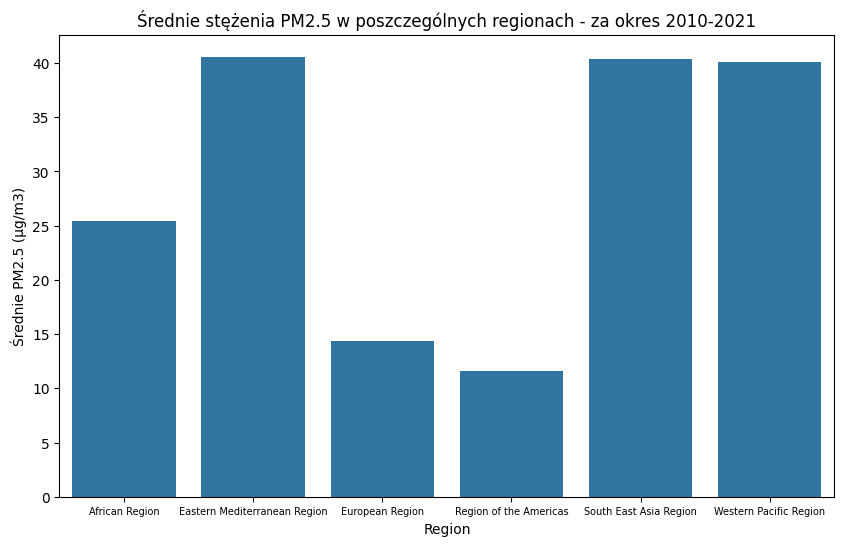

In [33]:
# Wykres słupkowy średnich stężeń zanieczyszczeń w poszczególnych regionach
mean_pm25_region = dane.groupby('WHO Region')['PM2.5 (μg/m3)'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_pm25_region, x='WHO Region', y='PM2.5 (μg/m3)')
plt.title('Średnie stężenia PM2.5 w poszczególnych regionach - za okres 2010-2021')
plt.xlabel('Region')
plt.xticks(fontsize=7)
plt.ylabel('Średnie PM2.5 (μg/m3)')
plt.show()


Wykres powyżej wskazuje na duże średnie stężenia PM2.5 w regionie Bliskiego Wschodu, Południowo-Wschodniej Azjii oraz Zachodniego Pacyfiku. Najniższe wartości występują dla regionu składającego się z Ameryki Południowej i Północnej. Europa ma niewiele większą średnią wartość od Ameryk.

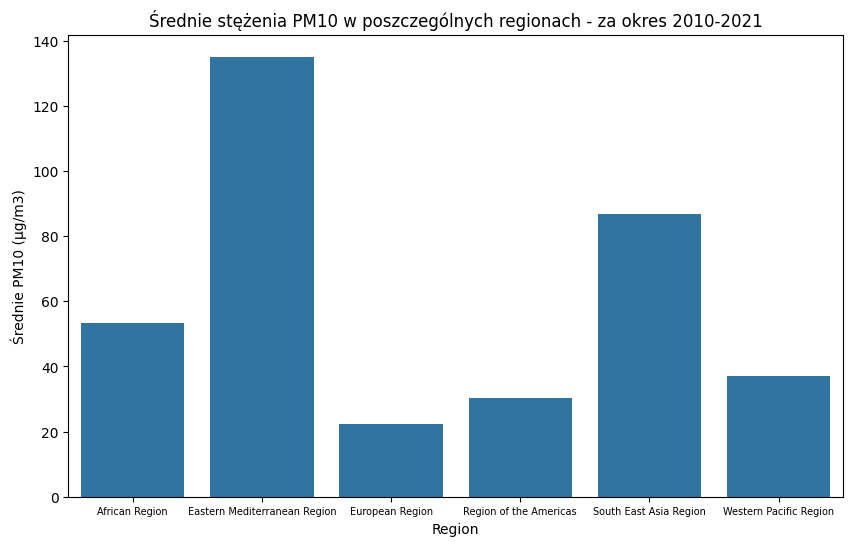

In [34]:
mean_pm10_region = dane.groupby('WHO Region')['PM10 (μg/m3)'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_pm10_region, x='WHO Region', y='PM10 (μg/m3)')
plt.title('Średnie stężenia PM10 w poszczególnych regionach - za okres 2010-2021')
plt.xlabel('Region')
plt.xticks(fontsize=7)
plt.ylabel('Średnie PM10 (μg/m3)')
plt.show()

Dla czynnika PM10 wartości są zbliżone, lecz występuje kilka zmian. Podobnie jak w przypadku PM2.5 największe wartości występują na Bliskim Wschodzie.
Duże zmiany wartości zachodzą dla regionu Zachodiego Pacyfiku, dlatego powinniśmy się przyjrzeć danym z tego regionu.

In [36]:
# Policzenie średnich stężeń dla Western Pacific Region dla PM2.5 i PM10
mean_pm25_western_pacific = dane[dane['WHO Region'] == 'Western Pacific Region']['PM2.5 (μg/m3)'].mean()
mean_pm10_western_pacific = dane[dane['WHO Region'] == 'Western Pacific Region']['PM10 (μg/m3)'].mean()
print("Średnie stężenie PM2.5 dla Western Pacific Region:", mean_pm25_western_pacific)
print("Średnie stężenie PM10 dla Western Pacific Region:", mean_pm10_western_pacific)
count_pm25_western_pacific = dane[dane['WHO Region'] == 'Western Pacific Region']['PM2.5 (μg/m3)'].count()
count_pm10_western_pacific = dane[dane['WHO Region'] == 'Western Pacific Region']['PM10 (μg/m3)'].count()
print("Liczba danych dla PM2.5 w Western Pacific Region:", count_pm25_western_pacific)
print("Liczba danych dla PM10 w Western Pacific Region:", count_pm10_western_pacific)

Średnie stężenie PM2.5 dla Western Pacific Region: 40.07489723756907
Średnie stężenie PM10 dla Western Pacific Region: 36.928012552301254
Liczba danych dla PM2.5 w Western Pacific Region: 4525
Liczba danych dla PM10 w Western Pacific Region: 478


Powyższe wyniki wskazują, że średnie stężenie PM10 jest mniejsze od stężenia PM2.5, co nie powinno mieć miejsca, gdyż PM10 jest zawsze stosunkowo większy od PM2.5. Taka sytuacja jest spowodowana blisko 10-krotną różnicą w posiadanych rekordach. Różnica w zliczanych rekordach do średnich sprawia, że porównanie obu czynników w regionie Zachodniego Pacyfiku nie jest wiarygodne.

Analizując resztę regionów możemy dostrzec zamianę miejscami Europy z Amerykami w porównaniu do wyników dla PM2.5

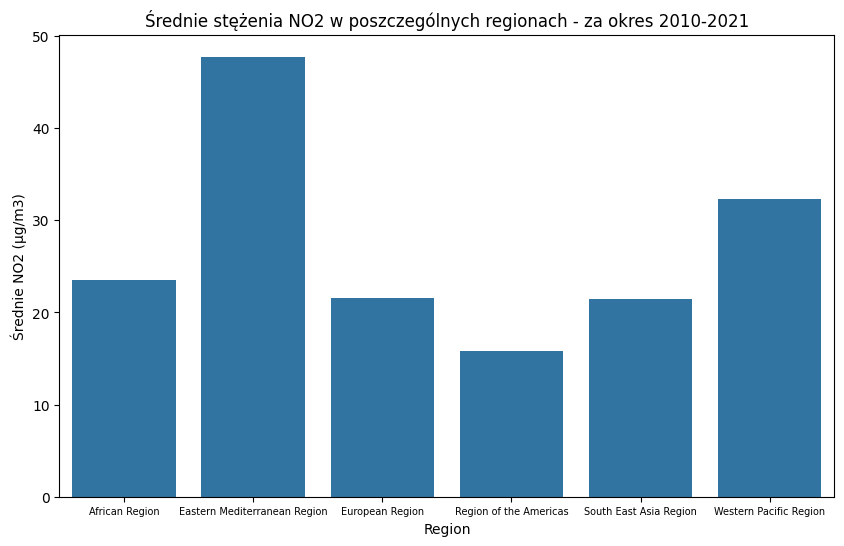

In [37]:
mean_no2_region = dane.groupby('WHO Region')['NO2 (μg/m3)'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_no2_region, x='WHO Region', y='NO2 (μg/m3)')
plt.title('Średnie stężenia NO2 w poszczególnych regionach - za okres 2010-2021')
plt.xlabel('Region')
plt.ylabel('Średnie NO2 (μg/m3)')
plt.xticks(fontsize=7)
plt.show()


Wyniki dla stężenia NO2 są już bardziej zbliżone do siebie. Ponownie najwyższe zbadane wartości są na Bliskim Wschodzie wynosząc blisko 50 μg/m3. Reszta wyników jest do siebie zbliżona i oscyluje w granicach 20-30 μg/m3. Najniższe wartości osiąga region Ameryk. 

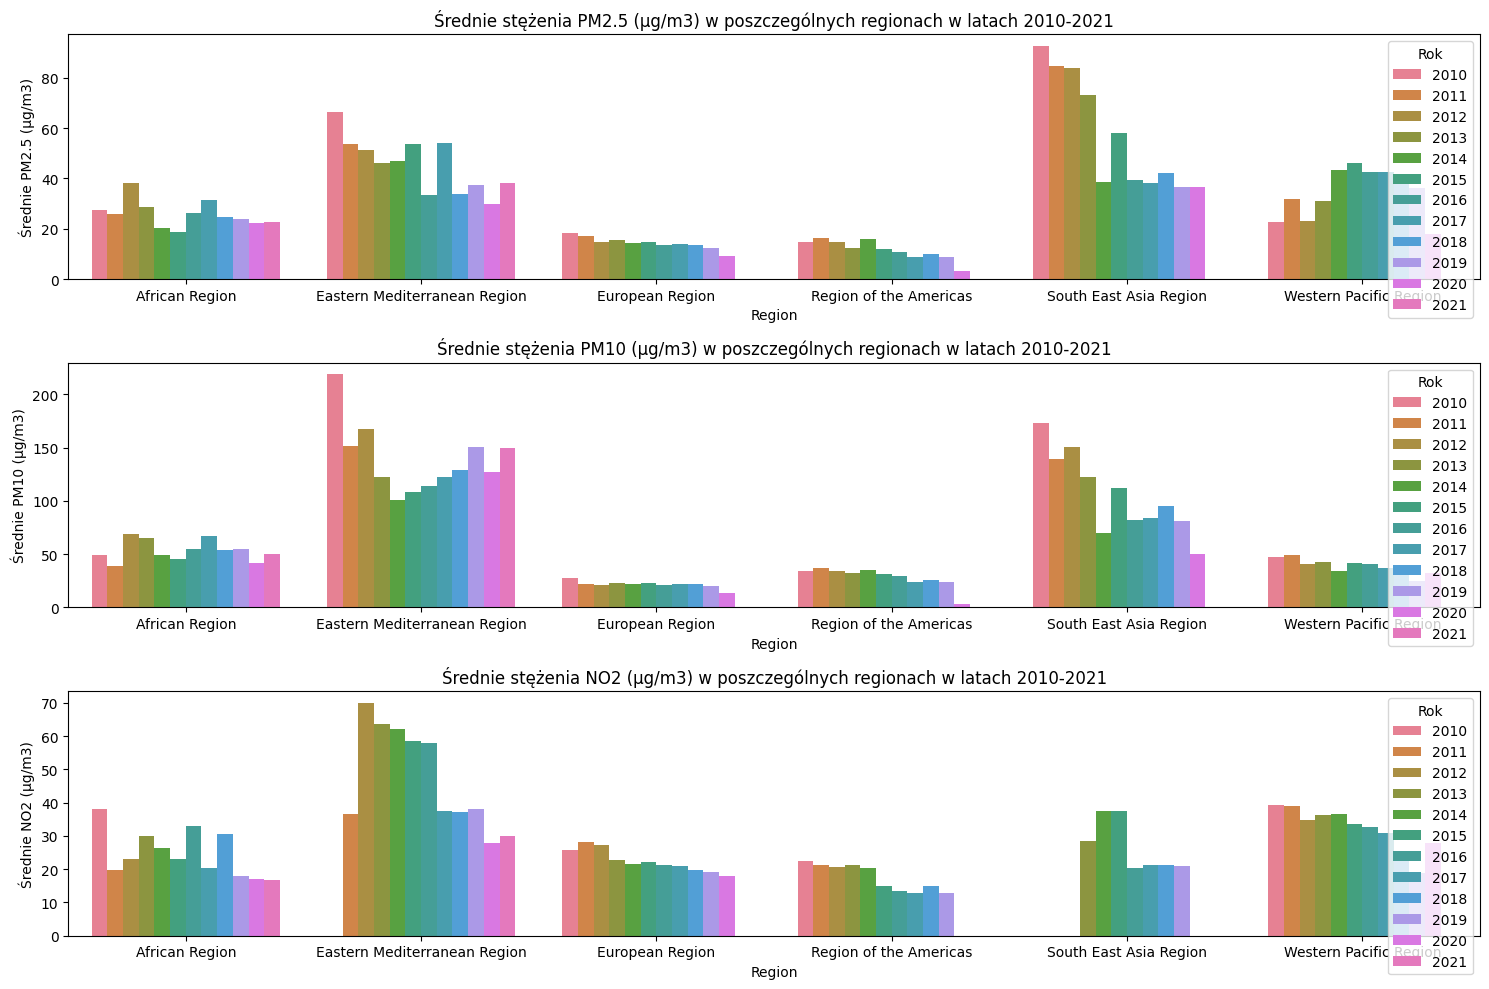

In [38]:
# Wykres słupkowy dla średnich stężeń zanieczyszczeń w poszczególnych regionach
plt.figure(figsize=(15, 10))

colors = sns.color_palette('husl', len(dane['Measurement Year'].unique()))

for i, pollutant in enumerate(['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']):
    # Grupowanie danych po roku i regionie oraz obliczenie średnich wartości dla danego roku i regionu
    mean_pollutant_year_region = dane.groupby(['Measurement Year', 'WHO Region'])[pollutant].mean().reset_index()
    
    plt.subplot(3, 1, i+1)
    sns.barplot(data=mean_pollutant_year_region, x='WHO Region', y=pollutant, hue='Measurement Year', palette=colors)
    plt.title(f'Średnie stężenia {pollutant} w poszczególnych regionach w latach {dane["Measurement Year"].min()}-{dane["Measurement Year"].max()}')
    plt.xlabel('Region')
    plt.ylabel(f'Średnie {pollutant}')
    plt.legend(title='Rok', loc='upper right')
    plt.tight_layout()

plt.show()

Wykresy powyżej pokazują jak średnie stężenie dla poszczególnych regionów zmienia się na przestrzeni lat. Podobnie jak w przypadku poprzednich wykresów możemy zauważyć, że kraje Bliskie Wschodu produkują średnio zanieczyszczenie o najwyższych wartościach badanych czynników. Równie duże wartości są zbadane w krajach Południowo-wschodniej Azji. Europa i Ameryki mają najniższe wartości wśród badanych regionów. W wielu przypadkach można zauważyć główny trend, który wskazuje na zmniejszanie się średnich wartości z roku na rok.

<Figure size 1200x800 with 0 Axes>

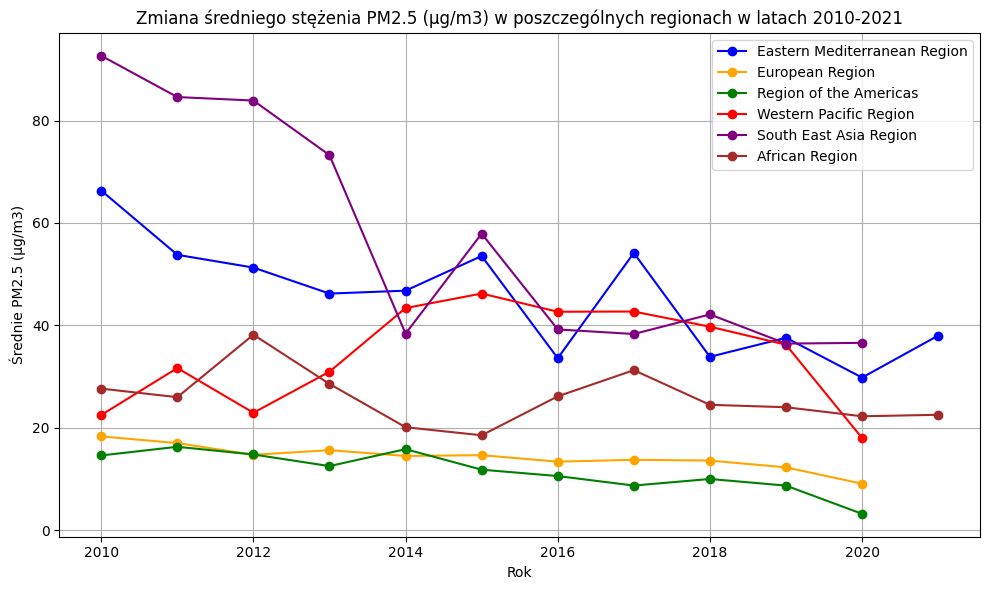

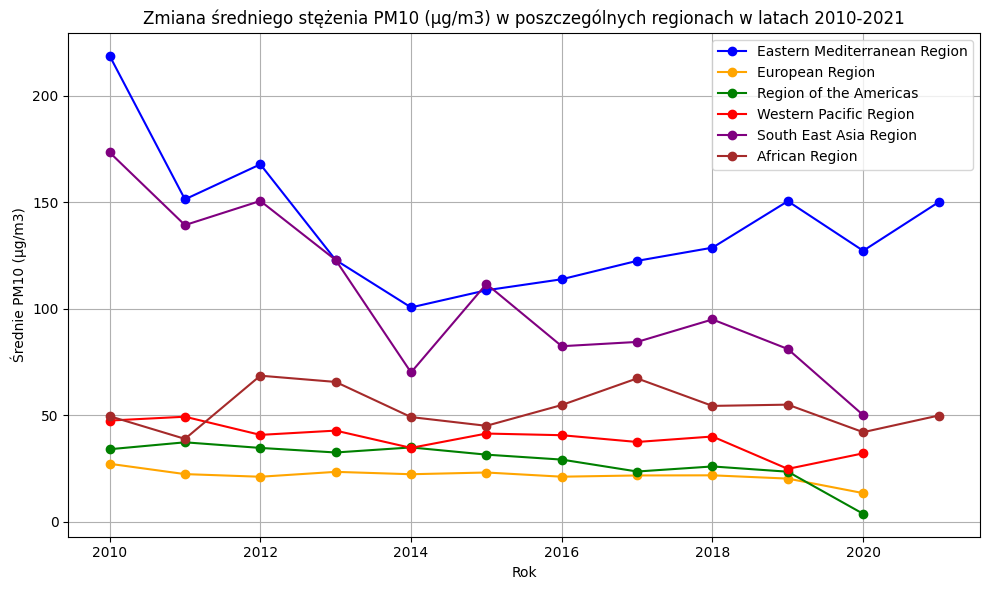

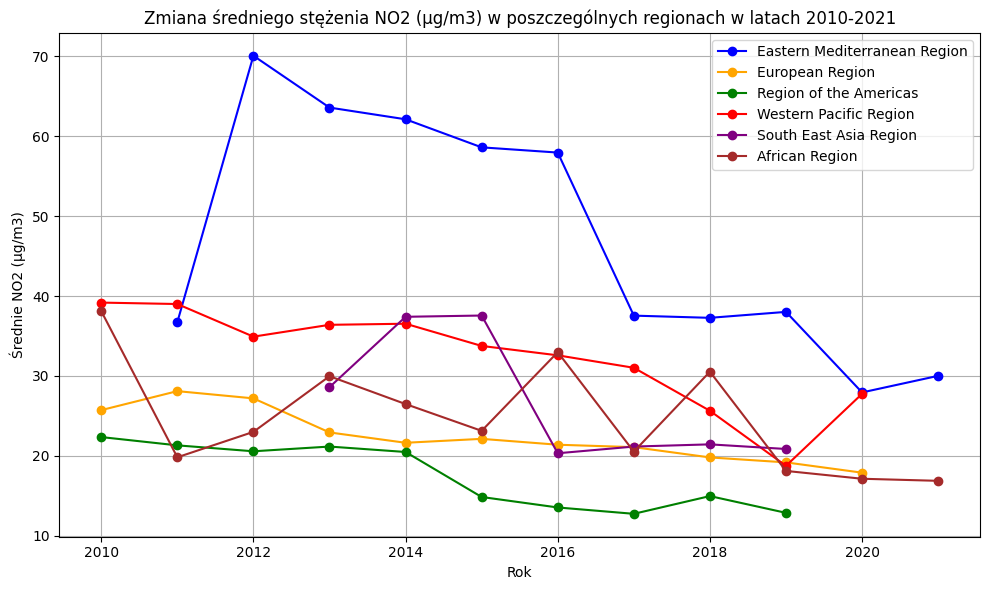

In [39]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

plt.figure(figsize=(12, 8))

for i, pollutant in enumerate(['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']):
    plt.figure(figsize=(10, 6))
    
    for j, region in enumerate(dane['WHO Region'].unique()):
        # Wybór danych dla danego regionu i zanieczyszczenia
        region_data = dane[dane['WHO Region'] == region]
        pollutant_data = region_data.groupby('Measurement Year')[pollutant].mean()
        
        # Tworzenie wykresu liniowego
        plt.plot(pollutant_data.index, pollutant_data.values, label=region, color=colors[j], marker='o')
    
    # Konfiguracja wykresu
    plt.title(f'Zmiana średniego stężenia {pollutant} w poszczególnych regionach w latach {dane["Measurement Year"].min()}-{dane["Measurement Year"].max()}')
    plt.xlabel('Rok')
    plt.ylabel(f'Średnie {pollutant}')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Na wykesach powyżej możemy zobaczyć wcześniej przedstawione dane w inny sposób, czyli na wykresach liniowych, które pokazują zmianę wartości w czasie.
Dla niektórych regionów możemy zobaczyć anomalne zmiany między sąsiednimi latami jest to spowodowane m.in. małą ilością próbek danych z danego roku.
Taki sposób wizualizacji bardzo dobrze pokazuje nam zmiany jakie zachodzą w poszczególnych regionach. Dla Europy, Ameryk widzimy powolny spadek zanieczyszczeń, nie jest on tak efektowny i wyraźny jak dla innych regionów. Jest to spowodowany punktem startowym, czyli średnią wartością dla roku 2010, gdzie Europa i Ameryki startują ze znacznie niższego pułapu niż inne regiony.

### Wnioski - Regiony

Najwyższe wartości współczynników zanieczyszczenia PM2.5, PM10 i NO2 występują w regionie Bliskiego Wschodu oraz Półudniowo-wschodniej Azji.
Taka sytuacja może być spowodowana mniejszą powszechnością badań i czujników umieszczanych w danych krajach. W krajach wchodzących w te regiony nie ma takiego ukierunkowania na ekologię jak w krajach europejskich czy amerykańskich. Regiony azjatyckie mają mniej miejsc, w których mierzone są pomiary. Prawdopodobnie czujniki umieszczane są w miejscach, gdzie jest świadomość dużego zanieczyszczenia tj. duże miasta i fabryki. W Europie jest dużo większa powszechność czujników, które występują w wielu miejscach. Analizując wartości na przestrzeni lat możemy zauważyć spadek współczynników zanieczyszczenia

## Analiza danych na poziomie Krajów:

In [40]:

def create_bar_chart(selected_pollutant, selected_region):
    # Filtracja danych dla wybranego regionu i czynnika
    selected_data = dane[dane['WHO Region'] == selected_region][['WHO Country Name', selected_pollutant]].dropna()

    # Zsumowanie średnich wartości dla każdego kraju
    summed_data = selected_data.groupby('WHO Country Name').mean().reset_index()

    fig = px.bar(summed_data, x='WHO Country Name', y=selected_pollutant,
                 title=f'Średnie zanieczyszczenie {selected_pollutant} w krajach regionu {selected_region}',
                 labels={selected_pollutant: f'Średnie {selected_pollutant}', 'WHO Country Name': 'Kraj'},
                 color_discrete_sequence=px.colors.qualitative.Plotly)
    
    fig.show()

# Wybór czynnika i regionu
select_pollutant = widgets.Dropdown(options=['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)'], description='Wybierz czynnik:')
select_region = widgets.Dropdown(options=dane['WHO Region'].unique(), description='Wybierz region:')

widgets.interactive(create_bar_chart, selected_pollutant=select_pollutant, selected_region=select_region)

interactive(children=(Dropdown(description='Wybierz czynnik:', options=('PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 …

## Wnioski

Powyższy wykres słupkowy pozwala na sprawdzenie najbardziej i najmniej zanieczyszczonych krajów wchodzących w wybrany region.

* PM2.5 - Eastern Mediterranean Region:
Najbardziej zanieczyszczonym krajem jest Afghanistan, lecz dane dlatego kraju pochodzą tylko z jednego miasta i z jednego kraju, dlatego pod uwagę powinniśmy wziąć Pakistan, który ma więcej rekordów w bazie danych. Najmniej zanieczyszczony kraj to Liban z średnią 24 μg/m3.
* PM2.5 - European Region:
Najbardziej zanieczyszczony kraj to: Tadżykistan, który uznawany jest jako region Europy, ale patrząc stricte na kraje europejskie to góruje Bośnia i Hercegowina ze średnią 46 μg/m3. Najmniej zanieczyszczonym krajem jest Islandia oraz kraje skandynawskie.
* PM2.5 - Region of the Americas:
Najbardziej zanieczyszczonym krajem jest: Gwatemala, natomiast najmniej zanieczyszczonym krjem są Bahamy, ale z tego kraju pochodzą jednie 4 rekordy. Warto zwrócić uwagę a Kanadę oraz USA, które mają niskie wartości zanieczyszczenia
* PM2.5 - Western Pacific Region:
Najbardziej zanieczyszczonym krajem jest Mongolia, ale nie posiada wielu rekordów. Bardzo dużo danych pochodzi z Chin, które również mają duże wartości.
Najmniej zanieczyszczony kraj to Australia i Nowa Zelandia
* PM2.5 - South East Asia Region:
Najbardziej zanieczyszczony kraj to Bangladesh ze średnią 75 μg/m3, natomiast najmniej zanieczyszczonym krajem jest Birma
* PM2.5 - African Region:
Najbardziej zanieczyszczony kraj to Kamerun, natomiast najmniej Kenia.



* PM10 - Eastern Mediterranean Region:
Podobnie jak we we wcześniejszym czynniku największe zanieczyszczenie - Pakistan, najmniejsze zanieczyszczenie - Liban.
* PM10 - European Region
Najbardziej zanieczyszczony kraj - Macedonia Północna, Najmniej zanieczyszczony kraj - Islandia
* PM10 - Region of the Americas:
Najbardziej zanieczyszczony kraj - Peru, Najmniej zanieczyszczony kraj - Kanada (nie licząc Bahamów)
* PM10 - Western Pacific Region:
Najbardziej zanieczyszczony kraj - Mongolia, Najmniej zanieczyszczony kraj - Australia i Nowa Zelandia
* PM10 - South East Asia Region:
Najbardziej zanieczyszczony kraj - Bangladesz, Najmniej zanieczyszczony kraj - Tajlandia
* PM10 - African Region:
Najbardziej zanieczyszczony kraj - Senegal i Uganda, Najmniej zanieczyszczony kraj - Kenia


* NO2 - Eastern Mediterranean Region:
Najbardziej zanieczyszczony kraj - Iran, Najmniej zanieczyszczony kraj - Pakistan

* NO2 - European Region:
Najbardziej zanieczyszczony kraj - Turcja i Serbia, Najmniej zanieczyszczony kraj - Estonia

* NO2 - Region of the Americas:
Najbardziej zanieczyszczony kraj - Kostaryka, Najmniej zanieczyszczony kraj - Trinidad i Tobago

* NO2 - Western Pacific Region:
Najbardziej zanieczyszczony kraj - Mongolia, Najmniej zanieczyszczony kraj - Australia

* NO2 - South East Asia Region:
Najbardziej zanieczyszczony kraj - Bangladesz, Najmniej zanieczyszczony kraj - Tajlandia

* NO2 - African Region:
Tylko dwa kraje prowadzą badania i oba mają 23 μg/m3



In [41]:
selected_pollutant = 'PM2.5 (μg/m3)'

grouped_data = dane.groupby('WHO Country Name')

# Filtrowanie danych, aby wybrać tylko kraje mające co najmniej 30 rekordów dla danego czynnika
filtered_data = grouped_data.filter(lambda x: (x[selected_pollutant].notna().sum()) >= 30)

# Pogrupowanie ponownie po kraju i obliczenie średniej wartości dla wybranego czynnika
average_pollution_by_country = filtered_data.groupby('WHO Country Name')[selected_pollutant].mean().reset_index()

# Sortowanie krajów na podstawie średniej wartości czynnika zanieczyszczenia
sorted_countries = average_pollution_by_country.sort_values(by=selected_pollutant)

top_5_most_polluted_countries = sorted_countries.tail(5)
top_5_least_polluted_countries = sorted_countries.head(5)

print("Najbardziej zanieczyszczone kraje:")
print(top_5_most_polluted_countries)

print("\nNajmniej zanieczyszczone kraje:")
print(top_5_least_polluted_countries)

Najbardziej zanieczyszczone kraje:
              WHO Country Name  PM2.5 (μg/m3)
22  Iran (Islamic Republic of)      32.909610
21                       India      39.880552
8                        China      43.081288
27                      Kuwait      53.898056
2                   Bangladesh      75.435593

Najmniej zanieczyszczone kraje:
   WHO Country Name  PM2.5 (μg/m3)
20          Iceland       5.753125
14          Estonia       6.170909
15          Finland       6.201909
45           Sweden       6.590199
6            Canada       6.653079


In [42]:
selected_pollutant = 'PM10 (μg/m3)'

grouped_data = dane.groupby('WHO Country Name')

filtered_data = grouped_data.filter(lambda x: (x[selected_pollutant].notna().sum()) >= 30)

average_pollution_by_country = filtered_data.groupby('WHO Country Name')[selected_pollutant].mean().reset_index()

sorted_countries = average_pollution_by_country.sort_values(by=selected_pollutant)

top_5_most_polluted_countries = sorted_countries.tail(5)
top_5_least_polluted_countries = sorted_countries.head(5)

print("Najbardziej zanieczyszczone kraje:")
print(top_5_most_polluted_countries)

print("\nNajmniej zanieczyszczone kraje:")
print(top_5_least_polluted_countries)

Najbardziej zanieczyszczone kraje:
              WHO Country Name  PM10 (μg/m3)
8                        China     72.396136
19                       India     89.557465
23                      Kuwait    122.829677
20  Iran (Islamic Republic of)    128.350735
2                   Bangladesh    139.452881

Najmniej zanieczyszczone kraje:
   WHO Country Name  PM10 (μg/m3)
18          Iceland      9.324375
12          Estonia     12.723000
13          Finland     13.364757
6            Canada     13.715830
21          Ireland     14.815968


In [43]:
selected_pollutant = 'NO2 (μg/m3)'

grouped_data = dane.groupby('WHO Country Name')

filtered_data = grouped_data.filter(lambda x: (x[selected_pollutant].notna().sum()) >= 30)

average_pollution_by_country = filtered_data.groupby('WHO Country Name')[selected_pollutant].mean().reset_index()

sorted_countries = average_pollution_by_country.sort_values(by=selected_pollutant)

top_5_most_polluted_countries = sorted_countries.tail(5)
top_5_least_polluted_countries = sorted_countries.head(5)

print("Najbardziej zanieczyszczone kraje:")
print(top_5_most_polluted_countries)

print("\nNajmniej zanieczyszczone kraje:")
print(top_5_least_polluted_countries)

Najbardziej zanieczyszczone kraje:
     WHO Country Name  NO2 (μg/m3)
24             Mexico    33.468696
2          Bangladesh    34.050556
39             Turkey    35.691416
8               China    36.521789
30  Republic of Korea    36.561326

Najmniej zanieczyszczone kraje:
   WHO Country Name  NO2 (μg/m3)
12          Estonia     6.892222
18          Iceland     7.530645
0         Australia    10.077895
6            Canada    11.461473
29         Portugal    13.263455


Kraje europejskie w porównaniu do krajów z innych regionów są dużo mniej zanieczyszczone, o czym świadczy Estonia oraz Islandia, które pojawiają się trzykrotnie na 1 i 2 miejscu najmniej zanieczyszczonych krajów. Do tego na tej liście pojawiają się kraje skandynawskie oraz Kanada.

Najbardziej zanieczyszczonymi krajami są kraje azjatyckie: Indie, Chiny, Bangladesz.

## Porównanie stopnia generalizacji analizy danych:

Analizując dane dla całego regionu uogólniamy ostateczny wynik, gdyż do regionu zalicza się wiele państw. Państwa mają różne charkterystyki i ogólne wynik dla całego regionu może zależeć od uprzemysłowienia, liczby ludności lub polityki klimatycznej/ekologicznej. Dlatego analiza jedynie regionu nie przyniosłaby oczekiwanych i rzetelnych rezultatów.

Przeprowadzenie analizy zanieczyszczenia na podstawie porównania wartości dla poszczególnych krajów, pozwala na wyodrębnienie krajów, które mają wyższe wartości zanieczyszczenia. Przykładowo dla Europy kraje bałkańskie, które są bardziej zanieczyszczone, ponieważ kultura "ekologiczna" jest tam niższa, mogą zawyżać ogólny wynik dla całego regionu. Ogólny trend dla wszystkich regionów wskazuje na zmniejszanie się zanieczyszczenia co świadczy o większej świadomości społecznej.

Podobnie jest w przypadku miast, dane pochodzące z krajów mniej rozwiniętych często pozyskiwane są jedynie z czujników umieszczanych w dużych miastach, które produkują większe zanieczyszczenie (samochody spalinowe, fabryki).

## Wnioski ogólne na temat zanieczyszczenia

Głównym wnioskiem, który można zauważyć jest różnica w produkowaniu zanieczyszczeń przez kraje bardziej rozwinięte i kraje mniej rozwinięte. W kraj bardziej rozwiniętych - Europa, Ameryka Północna, zanieczyszczenie jest dużo mniejsze niż w krajach azjatyckich. Europa bardziej dba o środowisko i reguluje prawnie produkcje zanieczyszczenie przez firmy (np. filtry) oraz osoby prywatne (np. samochody spalinowe). Kraje europejskie skupiają się na produkcji zielonej energii i odejściem od węgla kamiennego, co nie jest praktykowane np. w Chinach, gdzie znajduje się dużo elektrowni węglowych.

Kraje z mniejszą populacją generują często mniej zanieczyszczeń od krajów z dużą populacją. Czym więcej ludzi tym większ ilość odpadów i zanieczyszczeń.

Wartości PM2.5 i PM10 są często zależne od siebie i kraje mające dużą wartość zanieczyszczenia dla PM10, mają również duże wartości dla PM2.5.

W kwestii analizy zanieczyszczenia nie powinniśmy skupiać się na całym regionie i dokładnie porównywać go do innych regionów. Prowadzone badania w biedniejszych krajach lub w krajach mniej świadomych wykonuje się w miejscach, gdzie wiadomo o źródle zanieczyszczenia np. fabryki, duże miasta. W Europie jest rozmieszczonych dużo więcej czujników, które badają zanieczyszczenie. Porównanie regionu Europy do innych biedniejszych regionów nie przyniesie nam ciekawych wyników. Powinniśmy bardziej skupiać się na wewnętrznych wartościach dla krajów lub regionów.

## Zanieczyszczenie, a uczenie maszynowe

Analiza zanieczyszczenia powinna być istotnym kierunkiem w tworzeniu modeli uczenia maszynowego. Model, który przewidywałby zanieczyszczenie np. kolejnego dnia, byłby kluczowym elementem w ekologii i utrzymaniu zdrowia społeczeństwa. W danych są jedynie wartości dla czynników PM2.5, PM10 i NO2, ale jeżeliby stworzyć model działający w okresie dziennym oraz dodać do niego informacje o temperaturze, wilgotności, ciśnieniu i kierunku wiatru, utworzony zostałby model, który prowadzi predykcje zanieczyszczenia w kolejnym dniu.


## Podsumowanie

Eksploracyjna analiza danych pozwala nam na dokładną wizualizację danych nt. zanieczyszczenie powietrza dla regionu, kraju i miasta. Pozyskane dane dają nam możliwość wglądu jak wyglądała sytuacja zanieczyszczenia w okresie 2010-2021. Utworzone wizualizacje mapowe umożliwiają nam na umiejscowienie wyników w przestrzeni oraz porównanie ich międzdy regionami czy krajami. W danych widoczny jest trend, który wskazuje na zmniejszanie się zanieczyszczenia. Rozwój uczenia maszynowego w kwestii badania zanieczyszczenia powietza pozwola nam na wyciąganie wielu wniosków, dzięki porównaniu danych z ubiegłych lat możliwa jest predykcja dla lat nadchodzących